In [34]:
import random
from math import inf


params = {
    "farmer_productivity": 3,
    
    
    # "land_capacity": 120,

    "steal_rate": 3,
    "suppression_prob": 0.3,
    "confiscate_rate": 0.7,

    "tax_rate": .5,
    "soldier_base_pay": 2.0,

    "alpha_perception": 0.25,
    "fear_increment": 0.1,
    "fear_decay": 0.2,

    "utility_margin": 0.5,
    "switch_urge_threshold": 2.0,
}

EPS = 1e-6
FEAR_MAX = 10.0


# ------------------ PERSON CLASS ------------------ #

class Person:
    def __init__(self, role, wealth=0.0, prod_mult=1.0, aggr_mult=1.0, skill_mult=1.0):
        self.role = role
        self.wealth = max(0.0, wealth)

        # Psychology
        self.fear = 0.0
        self.perceived_violence = 0.0
        self.loyalty = random.uniform(0.8, 1.2)

        # Switching state
        self.next_role = role
        self.age_in_role = 0
        self.switch_cooldown = 3

        # Last-tick flows (mainly for logging, not utilities now)
        self.last_production = 0.0
        self.last_rob_gain = 0.0
        self.last_pay = 0.0

        # Heterogeneity
        self.prod_mult = random.uniform(0.9, 1.1)
        self.aggr_mult = random.uniform(0.9, 1.1)
        self.skill_mult = random.uniform(0.9, 1.1)

    # --- housekeeping ---
    def reset_for_new_tick(self):
        self.next_role = self.role
        self.age_in_role += 1
        if self.switch_cooldown > 0:
            self.switch_cooldown -= 1
        self.last_production = 0.0
        self.last_rob_gain = 0.0
        self.last_pay = 0.0

    # --- role helpers ---
    def is_farmer(self):  return self.role == "farmer"
    def is_bandit(self):  return self.role == "bandit"
    def is_soldier(self): return self.role == "soldier"

    # --- actions ---
    def produce(self, farmer_productivity, scale=1.0):
        if not self.is_farmer():
            return 0.0
        inc = max(0.0, self.prod_mult * farmer_productivity * max(0.0, scale))
        self.wealth = max(0.0, self.wealth + inc)
        self.last_production = inc
        return inc

    def attempt_rob(self, victim, steal_rate, fear_bump_robbed=0.3):
        if not (self.is_bandit() and victim and victim.role == "farmer"):
            return 0.0, False

        stolen = min(
            max(0.0, self.aggr_mult * steal_rate),
            max(0.0, victim.wealth),
        )
        if stolen <= 0:
            return 0.0, False

        victim.wealth = max(0.0, victim.wealth - stolen)
        victim.fear = min(FEAR_MAX, victim.fear + max(0.0, fear_bump_robbed))

        self.wealth = max(0.0, self.wealth + stolen)
        self.last_rob_gain = stolen
        return stolen, True

    def attempt_suppress(self, target_bandit, p_hit, confiscate_rate, fear_bump_suppressed=0.2):
        if not (self.is_soldier() and target_bandit and target_bandit.role == "bandit"):
            return 0.0, False

        hit_prob = max(0.0, min(1.0, self.skill_mult * p_hit))
        if random.random() >= hit_prob:
            return 0.0, False

        amt = min(
            max(0.0, self.skill_mult * confiscate_rate),
            max(0.0, target_bandit.wealth),
        )

        target_bandit.wealth = max(0.0, target_bandit.wealth - amt)
        target_bandit.fear = min(FEAR_MAX, target_bandit.fear + fear_bump_suppressed)

        self.wealth = max(0.0, self.wealth + amt)
        return amt, True

    def pay_tax(self, tax_rate):
        if not self.is_farmer():
            return 0.0
        tax_rate = max(0.0, min(1.0, tax_rate))
        tax = tax_rate * max(0.0, self.wealth)
        self.wealth = max(0.0, self.wealth - tax)
        return tax

    def receive_pay(self, amount):
        if amount > 0:
            self.wealth = max(0.0, self.wealth + amount)
            self.last_pay = amount

    # --- psychology ---
    def update_psychology(self, global_violence, alpha, fear_inc, fear_dec):
        a = max(0.0, min(1.0, alpha))
        gv = max(0.0, global_violence)

        # smoothed perception of violence
        self.perceived_violence = (1 - a) * self.perceived_violence + a * gv

        if self.perceived_violence > 0.5:
            self.fear = min(FEAR_MAX, self.fear + fear_inc)
        else:
            self.fear = max(0.0, self.fear - fear_dec)

    # --- forward-looking utility prediction ---
    def predicted_utility(self, role, world, params):
        """
        Predict this agent's utility NEXT TICK if they were 'role',
        given current world composition and last-tick violence.
        """

        # approx populations if THIS person changes role
        f = world.farmer_pop
        b = world.bandit_pop
        s = world.soldier_pop

        # remove self from current role
        if self.is_farmer():
            f -= 1
        elif self.is_bandit():
            b -= 1
        elif self.is_soldier():
            s -= 1

        # add self as 'role'
        if role == "farmer":
            f += 1
        elif role == "bandit":
            b += 1
        elif role == "soldier":
            s += 1

        violence = world.total_violence_last_tick

        # ---- farmer ----
        if role == "farmer":
            
            predicted_prod = self.prod_mult * params["farmer_productivity"]
            safety_bonus = max(0.0, 0.5 - 0.02 * violence)
            return predicted_prod + safety_bonus - 0.01 * b

        # ---- bandit ----
        if role == "bandit":
            if f > 0:
                base_rob = self.aggr_mult * params["steal_rate"]
            else:
                base_rob = 0.0
            return (
                base_rob
                - 0.01 * b                     # competition
                + 0.05 * max(0, f)        # more farmers => more loot
                - 0.02 * s                     # soldiers make life worse
            )

        # ---- soldier ----
        if role == "soldier":
           
            if f > 0:
                avg_prod = params["farmer_productivity"]
                tax_pool = f * avg_prod * params["tax_rate"]
            else:
                tax_pool = 0.0
        
            base_total = params["soldier_base_pay"] * s
            if s > 0:
                pay_per = (tax_pool + base_total) / s
            else:
                pay_per = params["soldier_base_pay"]
        
            return pay_per + 0.02 * b - 0.30
            
    # --- switching with 5-tick lockout ---
    def decide_switch(self, utilities, switch_urge_threshold, utility_margin, global_tick):
        # first few ticks: no switching at all
        if global_tick <= 5:
            self.next_role = self.role
            return

        if self.switch_cooldown > 0:
            self.next_role = self.role
            return

        urge = self.fear / (self.loyalty + EPS)
        current_u = utilities.get(self.role, -1e9)

        # if urge is low, they don't even consider switching
        if urge <= switch_urge_threshold:
            self.next_role = self.role
            return

        # choose best role by predicted utility
        best_role = self.role
        best_u = current_u
        for r, u in utilities.items():
            if u > best_u:
                best_role, best_u = r, u

        if best_u > current_u + utility_margin:
            self.next_role = best_role
        else:
            self.next_role = self.role

    def finalize_role_switch(self):
        if self.next_role != self.role:
            self.role = self.next_role
            self.age_in_role = 0
            self.switch_cooldown = 1  # small hysteresis

    # --- export for logging ---
    def to_dict(self):
        return {
            "role": self.role,
            "wealth": round(self.wealth, 3),
            "fear": round(self.fear, 3),
            "perceived_violence": round(self.perceived_violence, 3),
            "loyalty": round(self.loyalty, 3),
            "age_in_role": self.age_in_role,
        }


# ------------------ WORLD CLASS ------------------ #

class World:
    def __init__(self, n_farmers, n_bandits, n_soilders):
        self.people = []
        self.global_tick = 0

        for _ in range(n_farmers):
            self.people.append(Person("farmer", wealth=1.0))
        for _ in range(n_bandits):
            self.people.append(Person("bandit", wealth=0.7))
        for _ in range(n_soilders):
            self.people.append(Person("soldier", wealth=0.8))

        self.total_robberies = 0
        self.total_suppressions = 0
        self.total_violence_last_tick = 0.0  # for forward-looking utilities

        self.utilities_for_roles = {
            "farmer": 0.0,
            "bandit": 0.0,
            "soldier": 0.0,
        }

        self.update_population_counts()

        # for logging/diagnostics
        self.expected_prod_per_farmer = 0.0
        self.expected_rob_per_bandit = 0.0
        self.expected_soldier_pay = 0.0

    def update_population_counts(self):
        self.farmer_pop = sum(p.is_farmer() for p in self.people)
        self.bandit_pop = sum(p.is_bandit() for p in self.people)
        self.soldier_pop = sum(p.is_soldier() for p in self.people)

    def step(self):
        self.global_tick += 1

        for p in self.people:
            p.reset_for_new_tick()

        farmers = [p for p in self.people if p.is_farmer()]
        bandits = [p for p in self.people if p.is_bandit()]
        soldiers = [p for p in self.people if p.is_soldier()]

        # Production
        for f in farmers:
            f.produce(params["farmer_productivity"])

        # Robberies
        self.total_robberies = 0
        random.shuffle(bandits)
        for b in bandits:
            if not farmers:
                break
            target = max(farmers, key=lambda x: x.wealth)
            _, success = b.attempt_rob(target, params["steal_rate"])
            if success:
                self.total_robberies += 1

        # Suppression
        self.total_suppressions = 0
        bandits = [p for p in self.people if p.is_bandit()]
        for s in soldiers:
            if not bandits:
                break
            target = random.choice(bandits)
            _, success = s.attempt_suppress(
                target_bandit=target,
                p_hit=params["suppression_prob"],
                confiscate_rate=params["confiscate_rate"],
            )
            if success:
                self.total_suppressions += 1

        # Tax and pay soldiers
        tax_pool = sum(f.pay_tax(params["tax_rate"]) for f in farmers)
        total_base = params["soldier_base_pay"] * len(soldiers)
        pay_per = (tax_pool + total_base) / len(soldiers) if soldiers else 0.0
        for s in soldiers:
            s.receive_pay(pay_per)

        
        self.expected_prod_per_farmer = (
            sum(f.last_production for f in farmers) / len(farmers) if farmers else 0.0
        )
        self.expected_rob_per_bandit = (
            sum(b.last_rob_gain for b in bandits) / len(bandits) if bandits else 0.0
        )
        self.expected_soldier_pay = (
            sum(s.last_pay for s in soldiers) / len(soldiers) if soldiers else 0.0
        )

        # Violence this tick
        current_violence = self.total_robberies + self.total_suppressions
        self.total_violence_last_tick = current_violence

        # --- FORWARD-LOOKING ROLE UTILITIES ---
        # (average predicted utility across population)
        n = len(self.people) if self.people else 1

        self.expected_prod_per_farmer = (sum(p.last_production for p in farmers) / len(farmers) if farmers else 0.0)
        self.expected_rob_per_bandit = (sum(p.last_rob_gain for p in bandits) / len(bandits) if bandits else 0.0)
        self.expected_soldier_pay = (sum(p.last_pay for p in soldiers) / len(soldiers) if soldiers else 0.0)

        farmer_u = sum(
            p.predicted_utility("farmer", self, params) for p in self.people
        ) / n

        bandit_u = sum(
            p.predicted_utility("bandit", self, params) for p in self.people
        ) / n

        soldier_u = sum(
            p.predicted_utility("soldier", self, params) for p in self.people
        ) / n

        self.utilities_for_roles = {
            "farmer": max(1.5, max(farmer_u, self.expected_prod_per_farmer)),
            "bandit": max(1.5, max(bandit_u, self.expected_rob_per_bandit)),
            "soldier": max(1.5, max(soldier_u, self.expected_soldier_pay)-.5)
        }

        # Psychology update
        for p in self.people:
            p.update_psychology(
                global_violence=current_violence,
                alpha=params["alpha_perception"],
                fear_inc=params["fear_increment"],
                fear_dec=params["fear_decay"],
            )

        # Switching decisions ()
        for p in self.people:
            p.decide_switch(
                utilities=self.utilities_for_roles,
                switch_urge_threshold=params["switch_urge_threshold"],
                utility_margin=random.uniform(0.3, 2),
                global_tick=self.global_tick,
            )

        for p in self.people:
            p.finalize_role_switch()

        self.update_population_counts()

    def to_dict(self):
        return {
            "farmer_pop": self.farmer_pop,
            "bandit_pop": self.bandit_pop,
            "soldier_pop": self.soldier_pop,
            "total_robberies": self.total_robberies,
            "total_suppressions": self.total_suppressions,
            "utilities": self.utilities_for_roles,
            "exp_prod_farmer": self.expected_prod_per_farmer,
            "exp_rob_bandit": self.expected_rob_per_bandit,
            "exp_pay_soldier": self.expected_soldier_pay,
        }


# ------------------ SIMPLE TEST RUN ------------------ #

if __name__ == "__main__":
    world = World(n_farmers=92, n_bandits=100, n_soilders=100)

    for t in range(1, 101):
        world.step()
        state = world.to_dict()
        print(
            f"t={t:03d} | F={state['farmer_pop']:3d} "
            f"B={state['bandit_pop']:3d} S={state['soldier_pop']:3d} | "
            f"Robs={state['total_robberies']:2d} Supp={state['total_suppressions']:2d} | "
            f"U_F={state['utilities']['farmer']:.2f} "
            f"U_B={state['utilities']['bandit']:.2f} "
            f"U_S={state['utilities']['soldier']:.2f}"
        )


t=001 | F= 92 B=100 S=100 | Robs=100 Supp=32 | U_F=3.03 U_B=4.59 U_S=4.56
t=002 | F= 92 B=100 S=100 | Robs=100 Supp=30 | U_F=3.03 U_B=4.59 U_S=4.56
t=003 | F= 92 B=100 S=100 | Robs=100 Supp=21 | U_F=3.03 U_B=4.59 U_S=4.56
t=004 | F= 92 B=100 S=100 | Robs=100 Supp=30 | U_F=3.03 U_B=4.59 U_S=4.56
t=005 | F= 92 B=100 S=100 | Robs=100 Supp=32 | U_F=3.03 U_B=4.59 U_S=4.56
t=006 | F= 19 B=173 S=100 | Robs=100 Supp=34 | U_F=3.03 U_B=4.59 U_S=4.56
t=007 | F=  2 B= 98 S=192 | Robs=30 Supp=36 | U_F=3.07 U_B=1.50 U_S=4.93
t=008 | F=  2 B= 94 S=196 | Robs= 4 Supp=47 | U_F=3.07 U_B=1.50 U_S=3.17
t=009 | F=  2 B= 86 S=204 | Robs= 2 Supp=58 | U_F=3.07 U_B=1.50 U_S=3.09
t=010 | F= 15 B= 73 S=204 | Robs= 4 Supp=58 | U_F=3.07 U_B=1.50 U_S=2.93
t=011 | F= 15 B= 73 S=204 | Robs=73 Supp=66 | U_F=3.03 U_B=2.95 U_S=2.76
t=012 | F= 39 B= 49 S=204 | Robs=27 Supp=51 | U_F=3.03 U_B=1.50 U_S=2.76
t=013 | F= 56 B= 49 S=187 | Robs=49 Supp=69 | U_F=3.03 U_B=2.99 U_S=2.47
t=014 | F= 56 B= 49 S=187 | Robs=49 Supp=63 |

In [102]:
farmer_pop = []
bandit_pop = []
soldier_pop = []

farmer_ut = []
bandit_ut = []
soldier_ut = []

In [103]:
if __name__ == "__main__":
    world = World(n_farmers=100, n_bandits=100, n_soilders=100)

    for t in range(1, 101):
        world.step()
        state = world.to_dict()

        farmer_pop.append(world.farmer_pop)
        bandit_pop.append(world.bandit_pop)
        soldier_pop.append(world.soldier_pop)

        farmer_ut.append(state['utilities']['farmer'])
        bandit_ut.append(state['utilities']['bandit'])
        soldier_ut.append(state['utilities']['soldier'])
        
        print(
            f"t={t:03d} | F={state['farmer_pop']:3d} "
            f"B={state['bandit_pop']:3d} S={state['soldier_pop']:3d} | "
            f"Robs={state['total_robberies']:2d} Supp={state['total_suppressions']:2d} | "
            f"U_F={state['utilities']['farmer']:.2f} "
            f"U_B={state['utilities']['bandit']:.2f} "
            f"U_S={state['utilities']['soldier']:.2f}"
        )

t=001 | F=100 B=100 S=100 | Robs=100 Supp=37 | U_F=3.02 U_B=4.97 U_S=4.68
t=002 | F=100 B=100 S=100 | Robs=100 Supp=26 | U_F=3.02 U_B=4.97 U_S=4.68
t=003 | F=100 B=100 S=100 | Robs=100 Supp=27 | U_F=3.02 U_B=4.97 U_S=4.68
t=004 | F=100 B=100 S=100 | Robs=100 Supp=21 | U_F=3.02 U_B=4.97 U_S=4.68
t=005 | F=100 B=100 S=100 | Robs=100 Supp=30 | U_F=3.02 U_B=4.97 U_S=4.68
t=006 | F=  1 B=199 S=100 | Robs=100 Supp=26 | U_F=3.02 U_B=4.97 U_S=4.68
t=007 | F=  0 B= 99 S=201 | Robs= 1 Supp=25 | U_F=2.96 U_B=1.50 U_S=5.18
t=008 | F=  0 B= 98 S=202 | Robs= 0 Supp=63 | U_F=2.02 U_B=1.50 U_S=3.17
t=009 | F=  0 B= 91 S=209 | Robs= 0 Supp=62 | U_F=2.03 U_B=1.50 U_S=3.15
t=010 | F=  0 B= 77 S=223 | Robs= 0 Supp=55 | U_F=2.10 U_B=1.50 U_S=3.01
t=011 | F=  0 B= 62 S=238 | Robs= 0 Supp=66 | U_F=2.24 U_B=1.50 U_S=2.73
t=012 | F=  0 B= 49 S=251 | Robs= 0 Supp=72 | U_F=2.39 U_B=1.50 U_S=2.44
t=013 | F= 25 B= 29 S=246 | Robs= 0 Supp=82 | U_F=2.52 U_B=1.50 U_S=2.18
t=014 | F= 25 B= 69 S=206 | Robs=29 Supp=71 |

In [104]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame([farmer_pop, soldier_pop, bandit_pop])
df2 = pd.DataFrame([farmer_ut, soldier_ut, bandit_ut])

In [105]:
df = df.T.reset_index()
df2 = df2.T.reset_index()

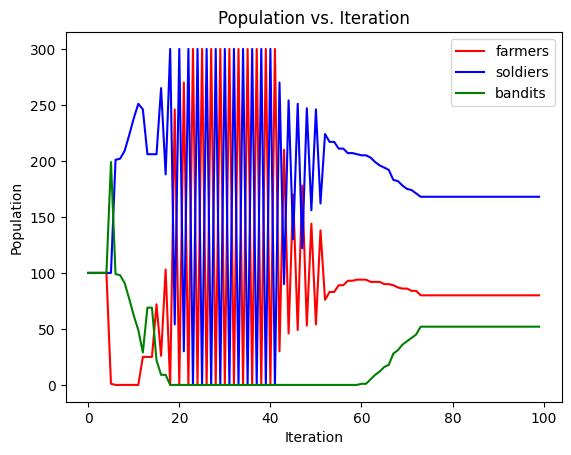

In [106]:
plt.plot(df['index'], df[0], c='r')
plt.plot(df['index'], df[1], c='b')
plt.plot(df['index'], df[2], c='g')
plt.title('Population vs. Iteration')
plt.ylabel('Population')
plt.xlabel('Iteration')
plt.legend(['farmers', 'soldiers', 'bandits'])

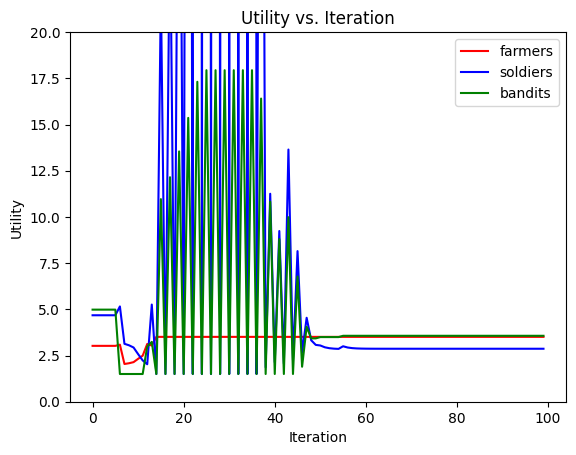

In [101]:
plt.plot(df2['index'], df2[0], c='r')
plt.plot(df2['index'], df2[1], c='b')
plt.plot(df2['index'], df2[2], c='g')
plt.title('Utility vs. Iteration')
plt.ylabel('Utility')
plt.xlabel('Iteration')
plt.ylim(0, 20)
plt.legend(['farmers', 'soldiers', 'bandits'])